In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Acceso a datos

### Hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


### Censo

In [3]:
schema = 'censo'
folder = 'censo_inegi_20_ageb_hex'
res = 9

query = f"SELECT * FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
censo_gdf = aup.gdf_from_query(query)

print(censo_gdf.shape)
censo_gdf.head(2)

(2514, 229)


,hex_id,res,geometry,cvegeo,nomgeo,city,type,pobtot,pobfem,pobmas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic
0,894983d8997ffff,9,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,1091.49990,586.0,505.50003,...,299.50003,442.99997,422.50003,301.0,325.5,156.25002,2.0,1.5,14.000001,0.0
1,894983c3697ffff,9,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,224.09999,112.5,111.60000,...,34.80000,75.60000,63.00000,36.6,39.9,22.80000,3.0,0.0,9.000000,0.0


### Delitos

In [4]:
del_gdf = gpd.read_file('../data/processed/Delitos_GDL_170101_231031_UTM_v1.geojson')
del_gdf.head(2)

DataSourceError: ../data/processed/Delitos_GDL_170101_231031_UTM_v1.geojson: No such file or directory

### Marginalization

In [5]:
schema = 'censo'
folder = 'nodes_marg_2020'

gdf = hex_gdf.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve().geometry.to_wkt()[0]
query = f"SELECT * FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"

nodes_marg = aup.gdf_from_query(query)
nodes_marg = nodes_marg.set_crs("EPSG:4326")
print(nodes_marg.shape)
nodes_marg.head(2)

(66512, 31)


,x,y,street_count,geometry,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,CVE_AGEB,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,-100.391268,20.613309,0,POINT (-100.39127 20.61331),2201400011227,22,014,0001,1227,2201400011227,...,0.0,0.0,0.0,0.000082,0.000574,0.003689,0.001066,0.006968,125.872895,0.983272
1,-100.390428,20.613587,0,POINT (-100.39043 20.61359),2201400011227,22,014,0001,1227,2201400011227,...,0.0,0.0,0.0,0.000082,0.000574,0.003689,0.001066,0.006968,125.872895,0.983272


In [6]:
nodes_marg.columns

Index(['x', 'y', 'street_count', 'geometry', 'cve_geo_ageb', 'cve_ent',
       'cve_mun', 'cve_loc', 'cve_ageb', 'CVE_AGEB', 'entidad', 'nom_ent',
       'mun', 'nom_mun', 'loc', 'nom_loc', 'ageb', 'pobtot', 'p6a14nae',
       'sbasc', 'psdss', 'ovsde', 'ovsee', 'ovsae', 'ovpt', 'ovsref', 'ovsint',
       'ovscel', 'ovhac', 'im_2020', 'imn_2020'],
      dtype='object')

## Spatial analysis

### Marginalization

In [7]:
nodes_hex = nodes_marg.overlay(hex_gdf, how='intersection')

nodes_pop = nodes_hex[['hex_id_9','pobtot']].groupby('hex_id_9').sum()
nodes_pop = nodes_pop.reset_index()
nodes_pop = nodes_pop.rename(columns={'pobtot':'pobtot_hex'})

nodes_hex = nodes_hex.merge(nodes_pop, on='hex_id_9')
nodes_hex['pct_pop'] = nodes_hex['pobtot'] / nodes_hex['pobtot_hex']

nodes_hex['wgt_im'] = nodes_hex['pct_pop'] * nodes_hex['im_2020']
nodes_hex['wgt_imn'] = nodes_hex['pct_pop'] * nodes_hex['imn_2020']

nodes_hex = nodes_hex[['hex_id_9','wgt_im','wgt_imn']].groupby(['hex_id_9']).sum()
nodes_hex = nodes_hex.reset_index()

print(nodes_hex.shape)
nodes_hex.head(2)

(2518, 3)


,hex_id_9,wgt_im,wgt_imn
0,8949822402fffff,118.541504,0.926002
1,89498224103ffff,116.939417,0.913487


In [8]:
hex_marg = hex_gdf.merge(nodes_hex, on='hex_id_9', how='left')
hex_marg = hex_marg.fillna(0)

### Crime

In [27]:
del_gdf = del_gdf.to_crs("EPSG:4326")
del_hex = del_gdf.overlay(hex_gdf, how='intersection')
del_hex = del_hex.groupby('hex_id_9').count()
del_hex = del_hex.rename(columns={'delito':'delitos_count'})

del_hex = del_hex.reset_index()
del_hex = del_hex[['hex_id_9','delitos_count']]

print(del_hex.shape)
del_hex.head(2)

(1121, 2)


,hex_id_9,delitos_count
0,89498c94003ffff,159
1,89498c94007ffff,102


In [28]:
del_hex = del_hex.merge(censo_gdf[['hex_id_9','pobtot']], on='hex_id_9', how='outer')
del_hex = del_hex.fillna(0)
del_hex.loc[del_hex.pobtot==0,'pobtot'] = 1
del_hex['del_hab'] = del_hex['delitos_count'] / del_hex['pobtot']
del_hex['del_hab_100'] = del_hex['del_hab'] * 100
hex_crime = hex_gdf.merge(del_hex, on='hex_id_9', how='left')
hex_crime = hex_crime.fillna(0)
print(hex_crime.shape)
hex_crime.head(2)

(1214, 10)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,delitos_count,pobtot,del_hab,del_hab_100
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,245.0,877.0,0.279361,27.936146
1,89498c9608bffff,"POLYGON ((-103.33820 20.62182, -103.33698 20.6...",14039,Guadalajara,Guadalajara,urban,12.0,1.0,12.000000,1200.000000


<AxesSubplot: >

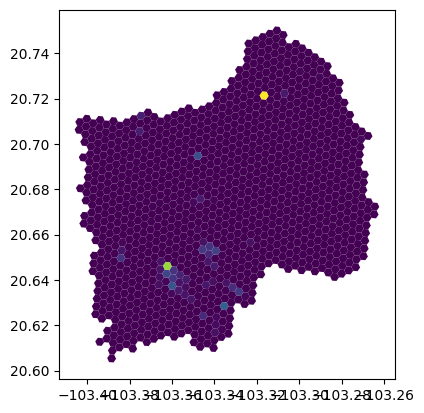

In [29]:
hex_crime.plot('del_hab_100')

### Cars per household

In [9]:
censo_gdf['auto_viv'] = censo_gdf['vph_autom'] / censo_gdf['tvivparhab']

### Socioeconomic level

In [10]:
from sklearn.preprocessing import StandardScaler

def pca(df, columns):
    """Create Principal Component Analysis from DataFrame and return Eigenvalues and Eigenvectors

    Args:
        df {pandas.DataFrame} -- DataFrame containing numeric columns for PCA
        columns {list} -- list with column names for PCA

    Returns:
        numpy.array, numpy.array -- array of Eigenvalues, array of Eigenvectors
    """

    features = np.array(df[columns]).T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)

    return values, vectors

def amai_nse(df, group_column_name):
    """Calculate Socioeconomic Levels (NSE) according to AMAI

    Args:
        df {pandas.DataFrame} -- DataFrame containing sociodemographic data for analysis at AGEB level
        df_nse {pandas.DataFrame} -- DataFrame with percentage of population by NSE and state
        state_name {string}: state name

    Returns:
        pandas.DataFrame -- DataFrame containing NSE for the specified state
    """
    #calculate indexes
    df['Idx_PC'] = df['vph_pc'].values / df[['vph_pc','vph_refri','vph_lavad','vph_tv']].max(axis=1)
    df['Idx_School'] = df['graproes'] / df['graproes'].max()
    df['Idx_PosBas'] = df['p18ym_pb'] / df['p_18ymas']

    #remove null in all columns
    idx = (df.Idx_PC.isnull())&(df.Idx_School.isnull())&(df.Idx_PosBas.isnull())
    df = df[~idx].copy()

    #fill missing data
    df['Idx_PC'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)
    df['Idx_School'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)
    df['Idx_PosBas'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)

    #pca
    values, vectors = pca(df, columns=['Idx_PC','Idx_School','Idx_PosBas'])

    #calculate nse index
    df['NSE_Idx'] = df.apply (
        lambda row: (values[0]*vectors[0,0]*row.loc['Idx_PC']+
                    values[0]*vectors[1,0]*row.loc['Idx_School']+
                    values[0]*vectors[2,0]*row.loc['Idx_PosBas']), axis=1)

    #standarize nse index values
    df['NSE_Idx'] = StandardScaler().fit_transform(np.array(df['NSE_Idx']).reshape(-1, 1))

    #sort by nse index
    df.sort_values('NSE_Idx', inplace=True)

    #calculate cumulative population and percentage
    df = df.assign(sum=df.pobtot.cumsum())
    df['pct_pob'] = df['sum'] / df['sum'].max()

    #filter DataFrame
    df = df[[group_column_name,'pobtot','Idx_PC','Idx_School',
    'Idx_PosBas','NSE_Idx']].copy()

    df.columns = df.columns.str.lower()

    # df[[c for c in df if c not in ['geometry']] + ['geometry']]

    return df

In [11]:
hex_nse = amai_nse(censo_gdf, 'hex_id')
hex_nse = hex_gdf.merge(hex_nse, right_on='hex_id',
                        left_on='hex_id_9', how='left')
print(hex_nse.shape)
hex_nse.head(2)

(2826, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,hex_id,pobtot,idx_pc,idx_school,idx_posbas,nse_idx
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,894983d8997ffff,1091.49990,0.885090,0.946223,0.929139,1.082073
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,894983c3697ffff,224.09999,0.771654,0.886684,0.867173,0.758296


<Axes: >

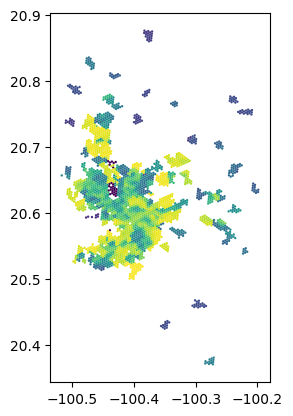

In [12]:
hex_nse.plot('nse_idx')

### Age group

In [13]:
censo_gdf.loc[censo_gdf.pobtot==0,'pobtot'] = 1
censo_gdf['pct_0_17'] = (censo_gdf['pobtot'] - censo_gdf['p_18ymas']) / censo_gdf['pobtot']
censo_gdf['pct_18_59'] = (censo_gdf['p_18ymas'] - censo_gdf['p_60ymas']) / censo_gdf['pobtot']
censo_gdf['pct_60_mas'] = censo_gdf['p_60ymas'] / censo_gdf['pobtot']

### Population density

In [16]:
censo_gdf['dens_pob_ha'] = censo_gdf['pobtot'] / (censo_gdf.to_crs("EPSG:6372").area/10000)

## Merge data

In [18]:
hex_socio = hex_gdf.merge(hex_nse[['hex_id_9','nse_idx']], on='hex_id_9', how='left')
# hex_socio = hex_socio.merge(del_hex[['hex_id_9','delitos_count','del_hab_100']], on='hex_id_9', how='left')
hex_socio = hex_socio.merge(censo_gdf[['hex_id','graproes','dens_pob_ha','auto_viv',
                                      'pct_0_17','pct_18_59','pct_60_mas']], left_on='hex_id_9',
                            right_on='hex_id', how='left')
hex_socio = hex_socio.merge(hex_marg[['hex_id_9','wgt_imn']], on='hex_id_9', how='left')
hex_socio = hex_socio.fillna(0)
print(hex_socio.shape)
hex_socio.head(2)

(2826, 15)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban,1.082073,894983d8997ffff,14.780002,89.544734,0.905081,0.250115,0.651626,0.098259,0.980891
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban,0.758296,894983c3697ffff,13.850000,18.383166,0.871094,0.294511,0.662651,0.042838,0.974732


In [20]:
hex_socio.to_file('../../../data/processed/hex_sociodemographic.geojson')